In [1]:
import math
import seaborn as sb
import numpy as np
from os.path import join, exists
from sklearn.linear_model import LogisticRegression, LinearRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import confusion_matrix, pairwise, roc_auc_score, roc_curve
from sklearn.feature_selection import VarianceThreshold, chi2, SelectKBest, SelectPercentile
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, RepeatedKFold
from sklearn.svm import SVC
import pandas as pd
from matplotlib import pyplot as plt
import cv2
from sklearn.pipeline import Pipeline

In [2]:
def flatten_cgrs(cgr_list):
    x = []
    for this_pair in cgr_list:
        first_half = list(np.reshape(this_pair[:,:,0], this_pair.shape[0]*this_pair.shape[1]))
        first_half = first_half / np.amax(first_half)
        second_half = list(np.reshape(this_pair[:,:,1], this_pair.shape[0]*this_pair.shape[1]))
        second_half = second_half / np.amax(second_half)
        x.append(first_half + second_half)
    return np.array(x)

def load_data(data_dir, kmers):
    fname = join(data_dir, f'AtGrand_{kmers}mers.npz')
    data = np.load(fname)
    train_x = flatten_cgrs(data['training_x'])
    train_y = data['training_y']
    valid_x = flatten_cgrs(data['validation_x'])
    valid_y = data['validation_y']
    test_x = flatten_cgrs(data['test_x'])
    test_y = data['test_y']
    return train_x, train_y, valid_x, valid_y, test_x, test_y

def plot_confusion_matrix(conf):
    # row = truth, column = prediction
    tn, fp = conf[0] # truth = negative
    fn, tp = conf[1] # truth = positive
    print('tp', tp, 'tn', tn, 'fp', fp, 'fn', fn)
    print('f1',tp/(tp+0.5*(fp+fn)))
    row_sums = conf.sum(axis=1)
    conf = conf / row_sums[:, np.newaxis]
    plt.imshow(conf, cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.yticks([0,1])
    plt.xticks([0,1])
    midp = (np.amax(conf)+np.amin(conf))/2
    for i in range(2):
        for j in range(2):
            if conf[i][j] > midp:
                colour = 'w'
            else:
                colour = 'k'
            plt.text(j,i,'{:.2f}'.format(conf[i][j]),c=colour)
    plt.show()

In [3]:
k = 4
data_dir = 'data/0000_datasets_as_used_in_paper/Arabidopsis_thaliana/'

# KNN

Number of neighbours vs. classification score


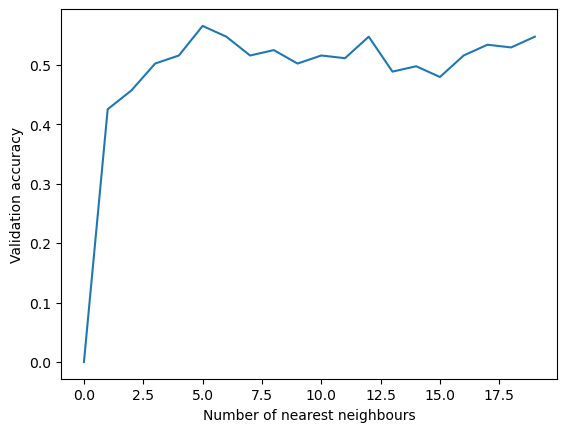

In [4]:
# Build a k-nearest neighbour model and train using the data in the given data directory.
def build_knn_model(data_dir, kmers, kneighbours, holdout):
    train_x, train_y, val_x, val_y, test_x, test_y = load_data(data_dir, kmers)
    clf = KNeighborsClassifier(n_neighbors=kneighbours).fit(train_x, train_y)
    if holdout:
        ys = clf.predict(test_x)
        scores = clf.score(test_x, test_y)
        cm = confusion_matrix(test_y, ys)
        return scores, cm
    else:
        ys = clf.predict(val_x)
        scores = clf.score(val_x, val_y)
        cm = confusion_matrix(val_y, ys)
        return scores, cm

def run_knn_exp():
    max_v = -math.inf
    max_i_dist = 0
    max_k = 20
    vs_dist = np.zeros((max_k,))
    for i in range(1, max_k):
        scores_temp, cm_temp = build_knn_model(data_dir, k, i, False)
        vs_dist[i] = scores_temp
        if scores_temp > max_v:
            max_v = scores_temp
            max_i_dist = i
    print('Number of neighbours vs. classification score')
    plt.plot(vs_dist)
    plt.xlabel('Number of nearest neighbours')
    plt.ylabel('Validation accuracy')
    plt.show()
    return max_i_dist

max_i_dist = run_knn_exp()

Score: 0.509009009009009
tp 65 tn 48 fp 64 fn 45
f1 0.5439330543933054


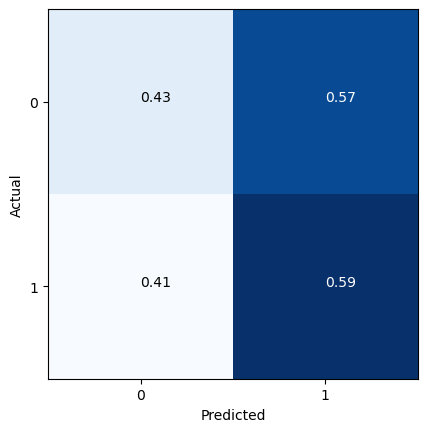

In [5]:
scores_dist, cm_dist = build_knn_model(data_dir, k, max_i_dist, True)
print('Score:',scores_dist)
plot_confusion_matrix(cm_dist)

## Regularised logistic regression

Logistic regression models the probability of a sample belonging to a binary class. Here it is a linear regression, trained on the training data and evaluated on the validation data.

### Linear

Score: 0.5294117647058824
tp 59 tn 58 fp 49 fn 55
f1 0.5315315315315315


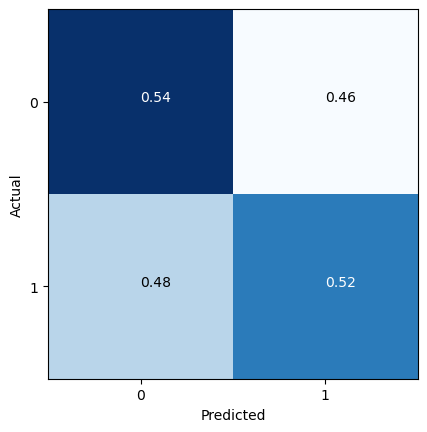

In [6]:
# Build a regularised logistic regression model and train using the data in the given data directory.
def build_rlr_model(data_dictionary, k):
    train_x, train_y, val_x, val_y, test_x, test_y = load_data(data_dictionary, k)
    clf = LogisticRegression(random_state=0, max_iter=500, class_weight='balanced').fit(train_x, train_y)
    ys = clf.predict(val_x)
    cm = confusion_matrix(val_y, ys)
    scores = clf.score(val_x, val_y)
    return scores, cm

def plot_linear_results():
    scores_dist, cm_dist = build_rlr_model(data_dir, k)
    print('Score:',scores_dist)
    plot_confusion_matrix(cm_dist)
    
plot_linear_results()

### Quadratic

/opt/miniconda3/envs/jupenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


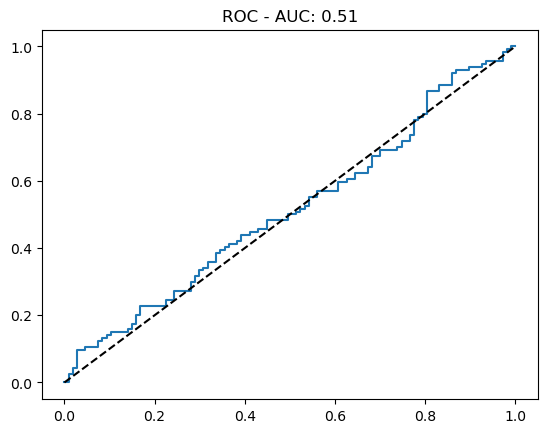

Score: 0.497737556561086
tp 58 tn 52 fp 55 fn 56
f1 0.5110132158590308


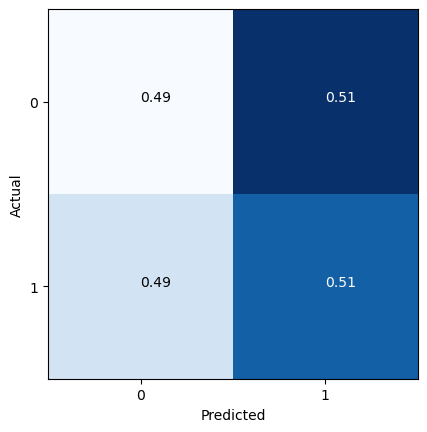

In [8]:
train_x, train_y, val_x, val_y, test_x, test_y = load_data(data_dir, k)
clf = Pipeline([('poly', PolynomialFeatures(degree=2, interaction_only=True)),
                  ('linear', LogisticRegression(max_iter=100, fit_intercept=False, verbose=0))])
clf = clf.fit(train_x, train_y)
y_pred = clf.predict(val_x)
cm = confusion_matrix(val_y, y_pred)
scores = clf.score(val_x, val_y)
ys = clf.predict_proba(val_x)
fpr, tpr, thresholds = roc_curve(val_y, ys[:,1])
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'k--')
plt.title('ROC - AUC: {:.2f}'.format(roc_auc_score(val_y, ys[:,1])))
plt.show()
print('Score:',scores)
plot_confusion_matrix(cm)

## Support Vector Classifier

Investigation of the Support Vector Classifier model

In [9]:
def run_svc_test(kernel, seed, degree=None, k=4, gamma='scale', c=1.0):
    print(kernel, degree, k)
    train_x, train_y, val_x, val_y, test_x, test_y = load_data(data_dir, k)
    if kernel == 'poly':
        svc = SVC(random_state=seed, kernel=kernel, degree=degree, gamma=gamma, C=c)
    else:
        svc = SVC(random_state=seed, kernel=kernel, gamma=gamma, C=c)
    svc.fit(train_x, train_y)
    score = svc.score(val_x, val_y)
    return score

def run_svc_holdout_test(kernel, seed, degree=None, k=4, gamma='scale', c=1.0):
    print(kernel, degree, k)
    if gamma not in ['scale','auto']:
        gamma = float(gamma)
    train_x, train_y, val_x, val_y, test_x, test_y = load_data(data_dir, k)
    if kernel == 'poly':
        svc = SVC(random_state=seed, kernel=kernel, degree=degree, gamma=gamma, C=c)
    else:
        svc = SVC(random_state=seed, kernel=kernel, gamma=gamma, C=c)
    svc.fit(train_x, train_y)
    score = svc.score(test_x, test_y)
    return score

In [10]:
results_ds = []
seed=0
for k in range(3,8):
    score_lin = run_svc_test('linear',seed,k=k)
    score_quad = run_svc_test('poly',seed,2,k=k)
    score_cubic = run_svc_test('poly',seed,3,k=k)
    score_rbf = run_svc_test('rbf',seed,k=k)
    results_ds.append([k, score_lin, score_quad, score_cubic, score_rbf])
results_ds_df = pd.DataFrame(results_ds, columns=['k','Linear','Quadratic','Cubic','RBF'])

linear None 3
poly 2 3
poly 3 3
rbf None 3
linear None 4
poly 2 4
poly 3 4
rbf None 4
linear None 5
poly 2 5
poly 3 5
rbf None 5
linear None 6
poly 2 6
poly 3 6
rbf None 6
linear None 7
poly 2 7
poly 3 7
rbf None 7


In [11]:
results_ds_df = pd.DataFrame(results_ds, columns=['k','Linear','Quadratic','Cubic','RBF'])

In [12]:
results_ds_df

,k,Linear,Quadratic,Cubic,RBF
0,3,0.520362,0.524887,0.542986,0.570136
1,4,0.538462,0.511312,0.520362,0.561086
2,5,0.425339,0.420814,0.402715,0.497738
3,6,0.384615,0.402715,0.425339,0.470588
4,7,0.398190,0.457014,0.466063,0.447964


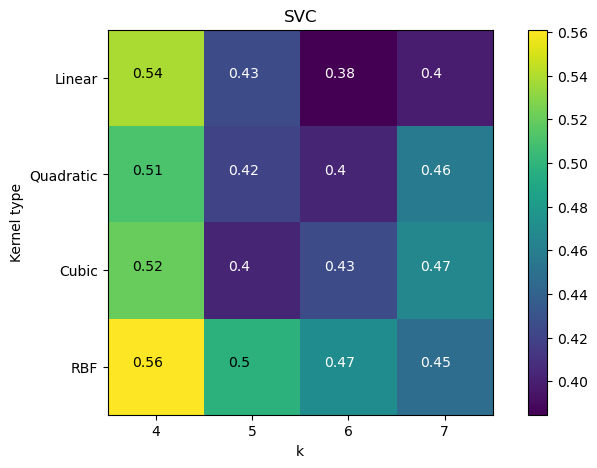

In [13]:
heatmap = []
ks_list = list(range(4,8))
kernel_list = ['Linear','Quadratic','Cubic','RBF']
for kernel in kernel_list:
    row = []
    for k in ks_list:
        res = results_ds_df.query(f'k == {k}')[kernel]
        if len(res) != 1:
            print(kernel, datasize)
            display(res)
        row.append(float(res))
    heatmap.append(row)
plt.figure(figsize=(9,5))
plt.imshow(heatmap)
mid = (np.max(heatmap) + np.min(heatmap))/2
for i in range(len(kernel_list)):
    for j in range(len(ks_list)):
        score = np.round(heatmap[i][j],decimals=2)
        if score < mid:
            c='White'
        else:
            c='Black'
        plt.text(j-0.25,i,score,color=c)
plt.yticks(range(len(kernel_list)),kernel_list)
plt.xticks(range(len(ks_list)),ks_list)
plt.xlabel('k')
plt.ylabel('Kernel type')
plt.title('SVC')
plt.colorbar()
plt.show()

In [14]:
list_train_x = []
list_valid_x = []
list_test_x = []
for k in range(4,8):
    train_x, train_y, val_x, val_y, test_x, test_y = load_data(data_dir, k)
    list_train_x.append(train_x)
    list_valid_x.append(val_x)
    list_test_x.append(test_x)
    print(train_x.shape, val_x.shape)

(663, 256) (221, 256)
(663, 1024) (221, 1024)
(663, 4096) (221, 4096)
(663, 16384) (221, 16384)


In [15]:
concat_train_x = np.concatenate(list_train_x, axis=1)
concat_valid_x = np.concatenate(list_valid_x, axis=1)
concat_test_x = np.concatenate(list_test_x, axis=1)
print(concat_train_x.shape)

(663, 21760)


In [16]:
svc = SVC(random_state=0, kernel='linear')
svc.fit(concat_train_x, train_y)
concat_linear_score = svc.score(concat_valid_x, val_y)
svc = SVC(random_state=0, kernel='poly',degree=2)
svc.fit(concat_train_x, train_y)
concat_quad_score = svc.score(concat_valid_x, val_y)
svc = SVC(random_state=0, kernel='poly',degree=3)
svc.fit(concat_train_x, train_y)
concat_cubic_score = svc.score(concat_valid_x, val_y)
svc = SVC(random_state=0, kernel='rbf')
svc.fit(concat_train_x, train_y)
concat_rbf_score = svc.score(concat_valid_x, val_y)

In [17]:
concat_scores={}
concat_scores['Linear']=concat_linear_score
concat_scores['Quadratic']=concat_quad_score
concat_scores['Cubic']=concat_cubic_score
concat_scores['RBF']=concat_rbf_score
print(concat_linear_score,concat_quad_score,concat_cubic_score,concat_rbf_score)

0.37104072398190047 0.4117647058823529 0.416289592760181 0.45248868778280543


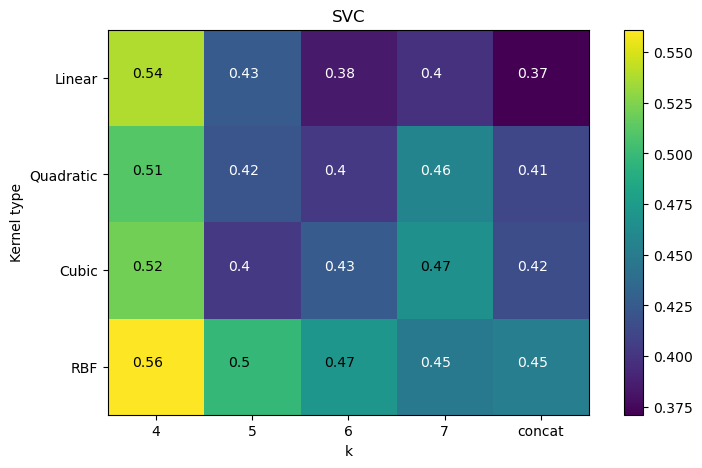

In [18]:
heatmap = []
ks_list = list(range(4,8))
kernel_list = ['Linear','Quadratic','Cubic','RBF']
for kernel in kernel_list:
    row = []
    for k in ks_list:
        res = results_ds_df.query(f'k == {k}')[kernel]
        if len(res) != 1:
            print(kernel, datasize)
            display(res)
        row.append(float(res))
    row.append(concat_scores[kernel])
    heatmap.append(row)
ks_list.append('concat')
plt.figure(figsize=(9,5))
plt.imshow(heatmap)
mid = (np.max(heatmap) + np.min(heatmap))/2
for i in range(len(kernel_list)):
    for j in range(len(ks_list)):
        score = np.round(heatmap[i][j],decimals=2)
        if score < mid:
            c='White'
        else:
            c='Black'
        plt.text(j-0.25,i,score,color=c)
plt.yticks(range(len(kernel_list)),kernel_list)
plt.xticks(range(len(ks_list)),ks_list)
plt.xlabel('k')
plt.ylabel('Kernel type')
plt.title('SVC')
plt.colorbar()
plt.show()

In [19]:
c_list = np.logspace(-3, 1, 5)
gamma_list = list(np.logspace(-3, 1, 5)) + ['scale', 'auto']
nonnn_filename = 'data/0006_non_nn_methods/nonNNmethods.csv'
if exists(nonnn_filename):
    results_ds_df= pd.read_csv(nonnn_filename)
else:
    results_ds = []
    seed=0
    for gamma in gamma_list:
        for c in c_list:
            for k in range(3,8):
                score_lin = run_svc_test('linear',seed,k=k,gamma=gamma,c=c)
                score_quad = run_svc_test('poly',seed,2,k=k,gamma=gamma,c=c)
                score_cubic = run_svc_test('poly',seed,3,k=k,gamma=gamma,c=c)
                score_rbf = run_svc_test('rbf',seed,k=k,gamma=gamma,c=c)
                score_sigmoid = run_svc_test('sigmoid',seed,k=k,gamma=gamma,c=c)
                results_ds.append([k, score_lin, score_quad, score_cubic, score_rbf, score_sigmoid, gamma, c])
    results_ds_df = pd.DataFrame(results_ds, columns=['k','Linear','Quadratic','Cubic','RBF','sigmoid','gamma','c'])
    results_ds_df.to_csv(nonnn_filename)

linear None 3
poly 2 3
poly 3 3
rbf None 3
sigmoid None 3
linear None 4
poly 2 4
poly 3 4
rbf None 4
sigmoid None 4
linear None 5
poly 2 5
poly 3 5
rbf None 5
sigmoid None 5
linear None 6
poly 2 6
poly 3 6
rbf None 6
sigmoid None 6
linear None 7
poly 2 7
poly 3 7
rbf None 7
sigmoid None 7
linear None 3
poly 2 3
poly 3 3
rbf None 3
sigmoid None 3
linear None 4
poly 2 4
poly 3 4
rbf None 4
sigmoid None 4
linear None 5
poly 2 5
poly 3 5
rbf None 5
sigmoid None 5
linear None 6
poly 2 6
poly 3 6
rbf None 6
sigmoid None 6
linear None 7
poly 2 7
poly 3 7
rbf None 7
sigmoid None 7
linear None 3
poly 2 3
poly 3 3
rbf None 3
sigmoid None 3
linear None 4
poly 2 4
poly 3 4
rbf None 4
sigmoid None 4
linear None 5
poly 2 5
poly 3 5
rbf None 5
sigmoid None 5
linear None 6
poly 2 6
poly 3 6
rbf None 6
sigmoid None 6
linear None 7
poly 2 7
poly 3 7
rbf None 7
sigmoid None 7
linear None 3
poly 2 3
poly 3 3
rbf None 3
sigmoid None 3
linear None 4
poly 2 4
poly 3 4
rbf None 4
sigmoid None 4
linear None 5


rbf None 4
sigmoid None 4
linear None 5
poly 2 5
poly 3 5
rbf None 5
sigmoid None 5
linear None 6
poly 2 6
poly 3 6
rbf None 6
sigmoid None 6
linear None 7
poly 2 7
poly 3 7
rbf None 7
sigmoid None 7
linear None 3
poly 2 3
poly 3 3
rbf None 3
sigmoid None 3
linear None 4
poly 2 4
poly 3 4
rbf None 4
sigmoid None 4
linear None 5
poly 2 5
poly 3 5
rbf None 5
sigmoid None 5
linear None 6
poly 2 6
poly 3 6
rbf None 6
sigmoid None 6
linear None 7
poly 2 7
poly 3 7
rbf None 7
sigmoid None 7
linear None 3
poly 2 3
poly 3 3
rbf None 3
sigmoid None 3
linear None 4
poly 2 4
poly 3 4
rbf None 4
sigmoid None 4
linear None 5
poly 2 5
poly 3 5
rbf None 5
sigmoid None 5
linear None 6
poly 2 6
poly 3 6
rbf None 6
sigmoid None 6
linear None 7
poly 2 7
poly 3 7
rbf None 7
sigmoid None 7
linear None 3
poly 2 3
poly 3 3
rbf None 3
sigmoid None 3
linear None 4
poly 2 4
poly 3 4
rbf None 4
sigmoid None 4
linear None 5
poly 2 5
poly 3 5
rbf None 5
sigmoid None 5
linear None 6
poly 2 6
poly 3 6
rbf None 6
sig

In [20]:
results_ds_df

,k,Linear,Quadratic,Cubic,RBF,sigmoid,gamma,c
0,3,0.484163,0.484163,0.484163,0.484163,0.484163,0.001,0.001
1,4,0.484163,0.484163,0.484163,0.484163,0.484163,0.001,0.001
2,5,0.484163,0.484163,0.484163,0.484163,0.484163,0.001,0.001
3,6,0.484163,0.484163,0.484163,0.484163,0.484163,0.001,0.001
4,7,0.484163,0.484163,0.484163,0.484163,0.484163,0.001,0.001
...,...,...,...,...,...,...,...,...
170,3,0.511312,0.547511,0.520362,0.529412,0.466063,auto,10.000
171,4,0.538462,0.538462,0.515837,0.542986,0.506787,auto,10.000
172,5,0.420814,0.484163,0.484163,0.466063,0.520362,auto,10.000
173,6,0.384615,0.484163,0.484163,0.461538,0.452489,auto,10.000


In [21]:
results_ds_df.sort_values(by='Linear', ascending=False)

,k,Linear,Quadratic,Cubic,RBF,sigmoid,gamma,c
60,3,0.556561,0.552036,0.511312,0.484163,0.484163,0.1,0.10
110,3,0.556561,0.538462,0.529412,0.484163,0.484163,10.0,0.10
35,3,0.556561,0.484163,0.484163,0.484163,0.484163,0.01,0.10
160,3,0.556561,0.484163,0.484163,0.484163,0.484163,auto,0.10
10,3,0.556561,0.484163,0.484163,0.484163,0.484163,0.001,0.10
...,...,...,...,...,...,...,...,...
159,7,0.375566,0.484163,0.484163,0.484163,0.484163,auto,0.01
109,7,0.375566,0.402715,0.470588,0.484163,0.484163,10.0,0.01
134,7,0.375566,0.484163,0.484163,0.484163,0.484163,scale,0.01
9,7,0.375566,0.484163,0.484163,0.484163,0.484163,0.001,0.01


In [22]:
results_ds_df.sort_values(by='Quadratic', ascending=False)

,k,Linear,Quadratic,Cubic,RBF,sigmoid,gamma,c
135,3,0.556561,0.565611,0.497738,0.484163,0.484163,scale,0.100
75,3,0.484163,0.552036,0.547511,0.484163,0.484163,1.0,0.001
60,3,0.556561,0.552036,0.511312,0.484163,0.484163,0.1,0.100
90,3,0.520362,0.552036,0.529412,0.570136,0.484163,1.0,1.000
105,3,0.484163,0.552036,0.529412,0.484163,0.484163,10.0,0.010
...,...,...,...,...,...,...,...,...
93,6,0.384615,0.366516,0.384615,0.484163,0.484163,1.0,1.000
98,6,0.384615,0.366516,0.384615,0.484163,0.484163,1.0,10.000
118,6,0.384615,0.366516,0.384615,0.484163,0.484163,10.0,1.000
103,6,0.484163,0.366516,0.384615,0.484163,0.484163,10.0,0.001


In [23]:
results_ds_df.sort_values(by='Cubic', ascending=False)

,k,Linear,Quadratic,Cubic,RBF,sigmoid,gamma,c
145,3,0.511312,0.542986,0.561086,0.538462,0.506787,scale,10.000
70,3,0.511312,0.542986,0.547511,0.542986,0.502262,0.1,10.000
80,3,0.484163,0.520362,0.547511,0.484163,0.484163,1.0,0.010
75,3,0.484163,0.552036,0.547511,0.484163,0.484163,1.0,0.001
65,3,0.520362,0.520362,0.547511,0.565611,0.484163,0.1,1.000
...,...,...,...,...,...,...,...,...
113,6,0.380090,0.366516,0.384615,0.484163,0.484163,10.0,0.100
68,6,0.384615,0.366516,0.384615,0.470588,0.533937,0.1,1.000
78,6,0.484163,0.366516,0.384615,0.484163,0.484163,1.0,0.001
118,6,0.384615,0.366516,0.384615,0.484163,0.484163,10.0,1.000


In [ ]:
results_ds_df.sort_values(by='RBF', ascending=False)

In [ ]:
results_ds_df.sort_values(by='sigmoid', ascending=False)

In [26]:
results_ds_df

,k,Linear,Quadratic,Cubic,RBF,sigmoid,gamma,c
0,3,0.484163,0.484163,0.484163,0.484163,0.484163,0.001,0.001
1,4,0.484163,0.484163,0.484163,0.484163,0.484163,0.001,0.001
2,5,0.484163,0.484163,0.484163,0.484163,0.484163,0.001,0.001
3,6,0.484163,0.484163,0.484163,0.484163,0.484163,0.001,0.001
4,7,0.484163,0.484163,0.484163,0.484163,0.484163,0.001,0.001
...,...,...,...,...,...,...,...,...
170,3,0.511312,0.547511,0.520362,0.529412,0.466063,auto,10.000
171,4,0.538462,0.538462,0.515837,0.542986,0.506787,auto,10.000
172,5,0.420814,0.484163,0.484163,0.466063,0.520362,auto,10.000
173,6,0.384615,0.484163,0.484163,0.461538,0.452489,auto,10.000


In [27]:
heatmap=[]
ks_list = list(range(3,8))
kernel_list = ['Linear','Quadratic','Cubic','RBF','sigmoid']
for k in ks_list:
    row = []
    for method in kernel_list:
        sorted_df = results_ds_df.query(f'k=={k}').sort_values(by=method, ascending=False)
        top_df = sorted_df.iloc[0]
        print(k, method, top_df[method])
        row.append(top_df[method])
    heatmap.append(row)
heatmap = np.transpose(heatmap)

3 Linear 0.5565610859728507
3 Quadratic 0.5656108597285068
3 Cubic 0.5610859728506787
3 RBF 0.583710407239819
3 sigmoid 0.5429864253393665
4 Linear 0.5384615384615384
4 Quadratic 0.5384615384615384
4 Cubic 0.5248868778280543
4 RBF 0.5610859728506787
4 sigmoid 0.5203619909502263
5 Linear 0.5113122171945701
5 Quadratic 0.5429864253393665
5 Cubic 0.497737556561086
5 RBF 0.497737556561086
5 sigmoid 0.5203619909502263
6 Linear 0.4841628959276018
6 Quadratic 0.48868778280542985
6 Cubic 0.4841628959276018
6 RBF 0.4841628959276018
6 sigmoid 0.5339366515837104
7 Linear 0.4841628959276018
7 Quadratic 0.4841628959276018
7 Cubic 0.4841628959276018
7 RBF 0.4841628959276018
7 sigmoid 0.502262443438914


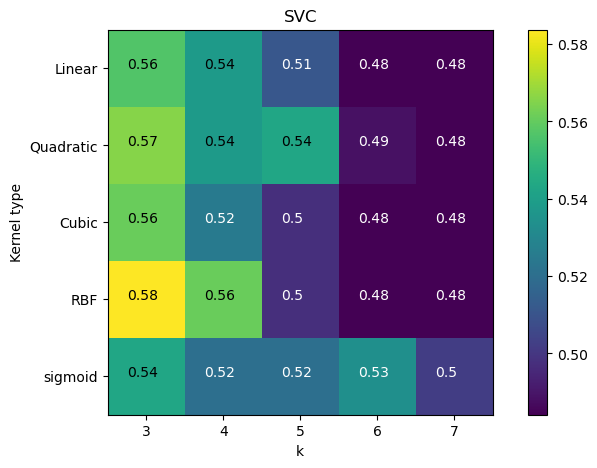

In [28]:
plt.figure(figsize=(9,5))
plt.imshow(heatmap)
mid = (np.max(heatmap) + np.min(heatmap))/2
for i in range(len(kernel_list)):
    for j in range(len(ks_list)):
        score = np.round(heatmap[i][j],decimals=2)
        if score < mid:
            c='White'
        else:
            c='Black'
        plt.text(j-0.25,i,score,color=c)
plt.yticks(range(len(kernel_list)),kernel_list)
plt.xticks(range(len(ks_list)),ks_list)
plt.xlabel('k')
plt.ylabel('Kernel type')
plt.title('SVC')
plt.colorbar()
plt.show()

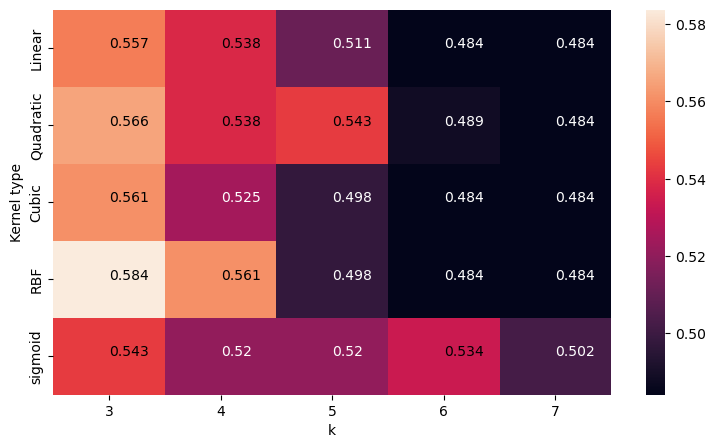

In [29]:
def draw_sb_heatmap(heatmap, labels_x, labels_y, label_x, label_y):
    plt.figure(figsize=(9,5))
    sb.heatmap(heatmap)
    mid = (np.max(heatmap) + np.min(heatmap))/2
    for i in range(len(labels_y)):
        for j in range(len(labels_x)):
            score = np.round(heatmap[i][j],decimals=3)
            if score < mid:
                c='White'
            else:
                c='Black'
            plt.text(j+0.5,i+0.5,score,color=c)
    plt.yticks(np.array(range(len(labels_y)))+0.5,labels_y)
    plt.xticks(np.array(range(len(labels_x)))+0.5,labels_x)
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    plt.show()
    
draw_sb_heatmap(heatmap, ks_list, kernel_list,'k','Kernel type')

Seems to increase with larger c value, so add a couple of larger values to check if we're missing the optimum range

In [31]:
results_ds = []
seed=0
for gamma in gamma_list:
    for c in [100,1000]:
        for k in range(3,8):
            score_lin = run_svc_test('linear',seed,k=k,gamma=gamma,c=c)
            score_quad = run_svc_test('poly',seed,2,k=k,gamma=gamma,c=c)
            score_cubic = run_svc_test('poly',seed,3,k=k,gamma=gamma,c=c)
            score_rbf = run_svc_test('rbf',seed,k=k,gamma=gamma,c=c)
            score_sigmoid = run_svc_test('sigmoid',seed,k=k,gamma=gamma,c=c)
            results_ds.append([k, score_lin, score_quad, score_cubic, score_rbf, score_sigmoid, gamma, c])
results_ds_df_part_2 = pd.DataFrame(results_ds, columns=['k','Linear','Quadratic','Cubic','RBF','sigmoid','gamma','c'])
results_ds_df=pd.concat((results_ds_df, results_ds_df_part_2))

linear None 3
poly 2 3
poly 3 3
rbf None 3
sigmoid None 3
linear None 4
poly 2 4
poly 3 4
rbf None 4
sigmoid None 4
linear None 5
poly 2 5
poly 3 5
rbf None 5
sigmoid None 5
linear None 6
poly 2 6
poly 3 6
rbf None 6
sigmoid None 6
linear None 7
poly 2 7
poly 3 7
rbf None 7
sigmoid None 7
linear None 3
poly 2 3
poly 3 3
rbf None 3
sigmoid None 3
linear None 4
poly 2 4
poly 3 4
rbf None 4
sigmoid None 4
linear None 5
poly 2 5
poly 3 5
rbf None 5
sigmoid None 5
linear None 6
poly 2 6
poly 3 6
rbf None 6
sigmoid None 6
linear None 7
poly 2 7
poly 3 7
rbf None 7
sigmoid None 7
linear None 3
poly 2 3
poly 3 3
rbf None 3
sigmoid None 3
linear None 4
poly 2 4
poly 3 4
rbf None 4
sigmoid None 4
linear None 5
poly 2 5
poly 3 5
rbf None 5
sigmoid None 5
linear None 6
poly 2 6
poly 3 6
rbf None 6
sigmoid None 6
linear None 7
poly 2 7
poly 3 7
rbf None 7
sigmoid None 7
linear None 3
poly 2 3
poly 3 3
rbf None 3
sigmoid None 3
linear None 4
poly 2 4
poly 3 4
rbf None 4
sigmoid None 4
linear None 5


In [32]:
results_ds_df.to_csv(nonnn_filename)
results_ds_df=pd.read_csv(nonnn_filename)

In [33]:
heatmap=[]
ks_list = list(range(3,8))
kernel_list = ['Linear','Quadratic','Cubic','RBF','sigmoid']
for k in ks_list:
    row = []
    for method in kernel_list:
        sorted_df = results_ds_df.query(f'k=={k}').sort_values(by=method, ascending=False)
        top_df = sorted_df.iloc[0]
        print(k, method, top_df[method])
        row.append(top_df[method])
    heatmap.append(row)
heatmap = np.transpose(heatmap)

3 Linear 0.5565610859728507
3 Quadratic 0.5656108597285068
3 Cubic 0.5610859728506787
3 RBF 0.583710407239819
3 sigmoid 0.5565610859728507
4 Linear 0.5429864253393665
4 Quadratic 0.5384615384615384
4 Cubic 0.5248868778280543
4 RBF 0.5610859728506787
4 sigmoid 0.5475113122171946
5 Linear 0.5113122171945701
5 Quadratic 0.5429864253393665
5 Cubic 0.502262443438914
5 RBF 0.497737556561086
5 sigmoid 0.5203619909502263
6 Linear 0.4841628959276018
6 Quadratic 0.4886877828054298
6 Cubic 0.4841628959276018
6 RBF 0.4841628959276018
6 sigmoid 0.5339366515837104
7 Linear 0.4841628959276018
7 Quadratic 0.4841628959276018
7 Cubic 0.4841628959276018
7 RBF 0.4841628959276018
7 sigmoid 0.5339366515837104
